## Feature Engineering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima, ARIMA, model_selection
import numpy as np
from sklearn.model_selection import ParameterGrid

### Reload Cleaned Data

In [2]:
import pandas as pd

# Load the cleaned data
df = pd.read_csv('data/cleaned_data.csv', parse_dates=['Datetime'], index_col='Datetime')


In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen,Laundry_Room,Water_Heater_AC
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Kitchen                float64
 5   Laundry_Room           float64
 6   Water_Heater_AC        float64
dtypes: float64(7)
memory usage: 126.7 MB


In [5]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Kitchen                  0
Laundry_Room             0
Water_Heater_AC          0
dtype: int64

### Create a Total Consumption Feature

In [6]:
# Create kWh consumption (Global_active_power in kW × minutes → kWh)
df['y'] = df['Global_active_power'] * (1 / 60)

### Agreggating the data on daily frequency

In [7]:
# Resample to daily level
df_daily = df.resample('D').agg({
    'y': 'sum',
    'Voltage': 'mean',
    'Global_reactive_power': 'mean',
    'Kitchen': 'sum',
    'Laundry_Room': 'sum',
    'Water_Heater_AC': 'sum'
})

In [8]:
df_daily.index

DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='Datetime', length=1442, freq='D')

In [9]:
df_daily.head()

,y,Voltage,Global_reactive_power,Kitchen,Laundry_Room,Water_Heater_AC
Datetime,,,,,,
2006-12-16,20.152933,236.243763,0.088187,0.0,546.0,4926.0
2006-12-17,56.507667,240.087028,0.156949,2033.0,4187.0,13341.0
2006-12-18,36.730433,241.231694,0.112356,1063.0,2621.0,14018.0
2006-12-19,27.769900,241.999313,0.104821,839.0,7602.0,6197.0
2006-12-20,37.095800,242.308062,0.111804,0.0,2648.0,14063.0


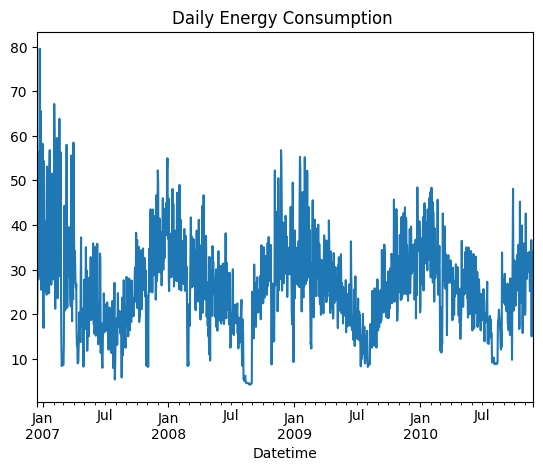

In [10]:
import matplotlib.pyplot as plt
# Daily energy consumption line plot
df_daily['y'].plot(title = 'Daily Energy Consumption ')
plt.show()

C:\Users\mouad\AppData\Local\Temp\ipykernel_23236\1322419492.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_plot(df_daily['y'].resample('M').mean(),


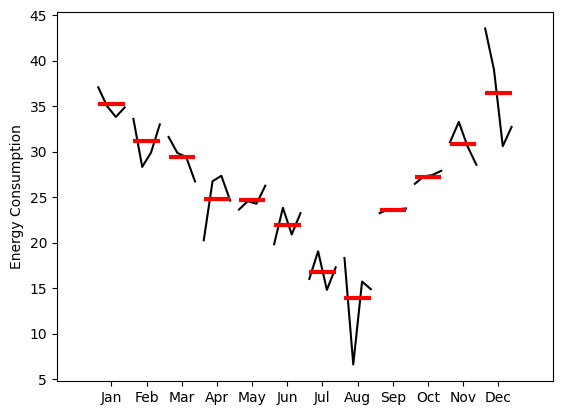

In [11]:
# Plotting the monthly seasonality of the energy consumption
month_plot(df_daily['y'].resample('M').mean(),
           ylabel = 'Energy Consumption')
plt.show()

C:\Users\mouad\AppData\Local\Temp\ipykernel_23236\2564144043.py:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(df_daily['y'].resample('Q').mean(),


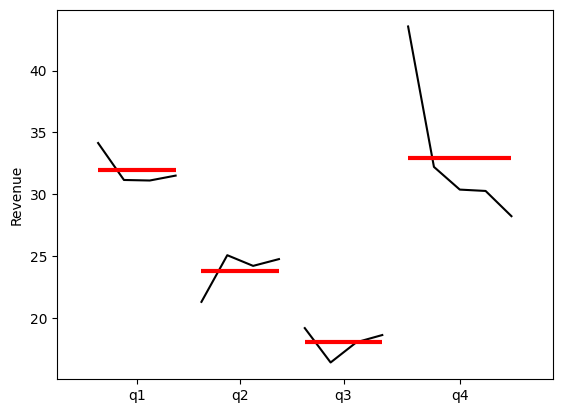

In [12]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of revenue values
# .resample('Q') - to convert the time series data into quarterly seasonality
quarter_plot(df_daily['y'].resample('Q').mean(),
           ylabel = 'Revenue')
plt.show()

`seasonal_decompose` - To decompose a time series into its constituent parts to better understand the underlying patterns.

components

- Trend: The overall direction of the series (increasing, decreasing, or stable).
- Seasonal: Repeating patterns at fixed intervals (e.g., daily, weekly, monthly).
- Residual: The remaining variation after removing trend and seasonal components.

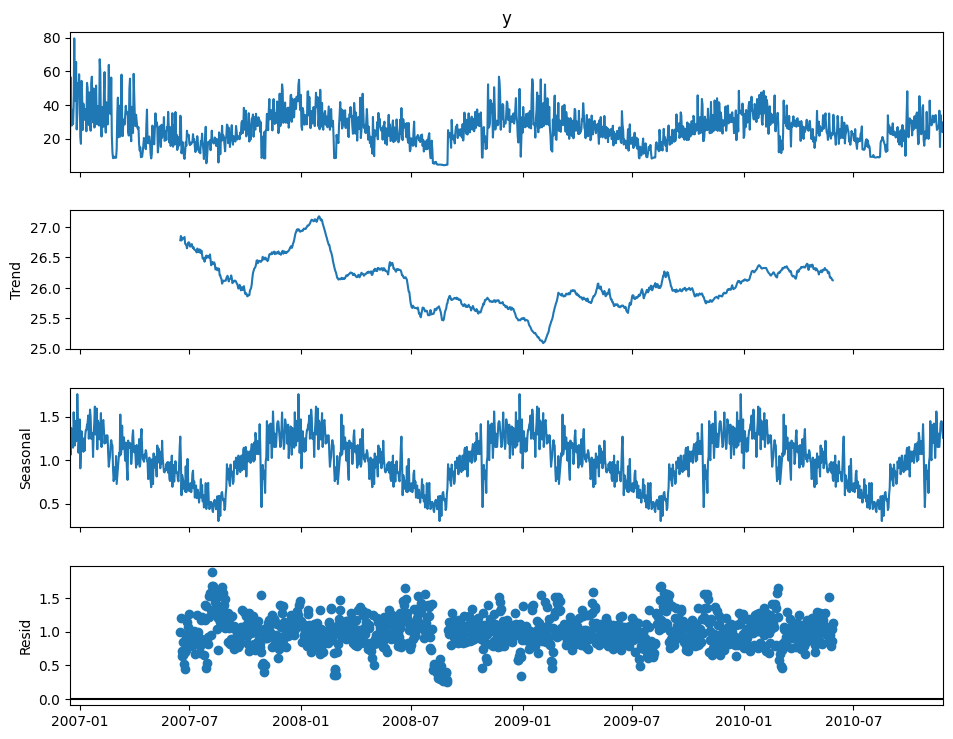

In [13]:
# Seasonal Decomposition Plots for Revenue Data
# Multiplicative model type, with daily seasonality (365 days)
decomposition = seasonal_decompose(df_daily['y'],
                                   model = 'mul',
                                   period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

## Autocorrelation

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.


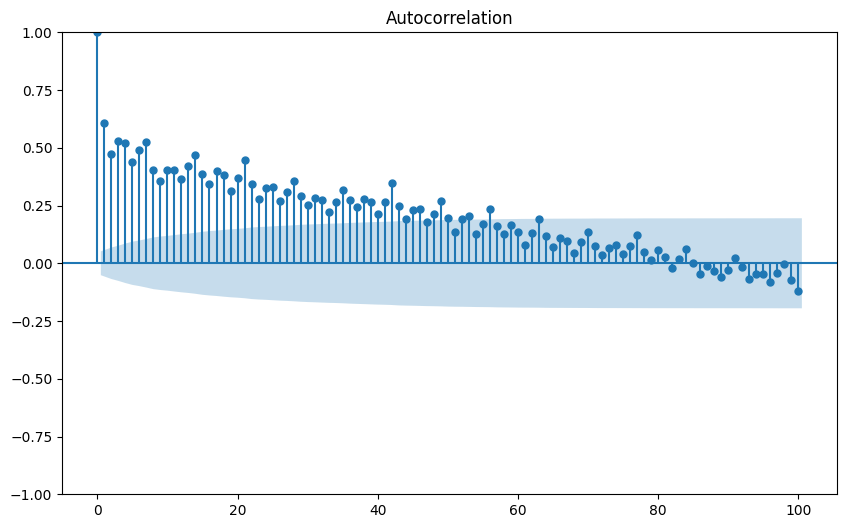

In [14]:
# Plot the autocorrelation (ACF)
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df_daily['y'], lags = 100, ax = ax)
plt.show()

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

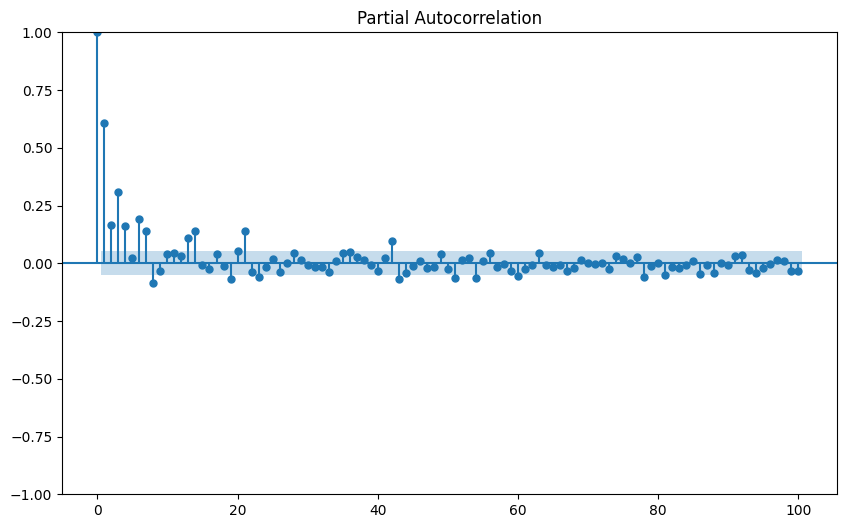

In [16]:
# Plot the partial autocorrelation (PACF)
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df_daily['y'], lags = 100, ax = ax)
plt.show()

## Stationarity

`adfuller` - used to perform the Augmented Dickey-Fuller test, which is a statistical test for testing the stationarity of a time series

 Stationarity implies that the statistical properties of the time series, such as mean and variance, do not change over time.

 The test evaluates a null hypothesis that the time series is non-stationary. If the p-value obtained from the test is less than a significance level (commonly 0.05), we reject the null hypothesis and conclude that the time series is stationary.

In [18]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
# 'result' contains the test statistic and the p-value.
result = adfuller(df_daily.y)
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")


p-value: 0.003972
Evidence suggests that the time series is stationary.


In [19]:
df_daily.to_csv('data/daily_data.csv', index=True)